<a href="https://colab.research.google.com/github/mithila20/CSE299/blob/main/Feedback_Analysis2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [1]:
!git clone https://github.com/imostafizur/Feedback_Analysis.git

Cloning into 'Feedback_Analysis'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 100 (delta 62), reused 46 (delta 26), pack-reused 0
Receiving objects: 100% (100/100), 17.54 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [2]:
!pip install transformers

# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

# Data processing

### Loading Dataset

In [4]:
df = pd.read_csv('/content/Feedback_Analysis/Dataset/updated_merged_dataset.csv')
df.head()

<ipython-input-4-b51e4e03a670>:1: DtypeWarning: Columns (0,1,2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Feedback_Analysis/Dataset/updated_merged_dataset.csv')


,product_id,product_brand,product_model_name,name,rating,verified,title,body,helpfulVotes
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,NaN,NaN,NaN,NaN,NaN,NaN
1,B0009N5L7K,Motorola,Motorola I265 phone,NaN,NaN,NaN,NaN,NaN,NaN
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,NaN,NaN,NaN,NaN,NaN,NaN
3,B001AO4OUC,Motorola,Motorola i335 Cell Phone Boost Mobile,NaN,NaN,NaN,NaN,NaN,NaN
4,B001DCJAJG,Motorola,Motorola V365 no contract cellular phone AT&T,NaN,NaN,NaN,NaN,NaN,NaN


###List all the column

In [5]:
list_of_columns = df.columns.tolist()
print(list_of_columns)


['product_id', 'product_brand', 'product_model_name', 'name', 'rating', 'verified', 'title', 'body', 'helpfulVotes']


### Drop 'product_id',  'product_model_name', 'name', 'rating', 'verified', 'title', 'helpfulVotes'

In [6]:
df.drop(['product_id', 'product_model_name', 'name', 'rating', 'verified', 'title', 'helpfulVotes'], axis=1, inplace=True)
df.head()


,product_brand,body
0,NaN,NaN
1,Motorola,NaN
2,Motorola,NaN
3,Motorola,NaN
4,Motorola,NaN


### Cunt number of NaN in product_brand and body

In [7]:
nan_product_brand = df['product_brand'].isna().sum()
nan_body = df['body'].isna().sum()

print(f"Number of NaN in product_brand: {nan_product_brand}")
print(f"Number of NaN in body: {nan_body}")


Number of NaN in product_brand: 68910
Number of NaN in body: 1492


In [8]:

df.dropna(subset=['product_brand', 'body'], inplace=True)

nan_product_brand = df['product_brand'].isna().sum()
nan_body = df['body'].isna().sum()

print(f"Number of NaN in product_brand: {nan_product_brand}")
print(f"Number of NaN in body: {nan_body}")


Number of NaN in product_brand: 0
Number of NaN in body: 0


###Save the cleaned dataset

In [9]:
df.to_csv('cleaned_dataset.csv')

### Load the cleaned dataset

In [10]:
df = pd.read_csv('/content/cleaned_dataset.csv')
df.head()

,Unnamed: 0,product_brand,body
0,1454,Motorola,DON'T BUY OUT OF SERVICE
1,1455,Motorola,I have been with nextel for nearly a year now ...
2,1456,Motorola,"I just got it and have to say its easy to use,..."
3,1457,Motorola,1 star because the phones locked so I have to ...
4,1458,Motorola,The product has been very good. I had used thi...


### Drop Unnamed: 0

In [11]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)


### Show number of column

In [12]:
num_columns = len(df.columns)
print(f"Number of columns: {num_columns}")

Number of columns: 2


###Dataset size

In [13]:
num_rows = len(df)
print(f"Number of rows: {num_rows}")

Number of rows: 67760


### Make the dataset small. Number of rows: 500

In [14]:
df = df.head(500)

In [15]:
df.to_csv('cleaned_dataset.csv')

In [16]:
num_rows = len(df)
print(f"Number of rows: {num_rows}")

Number of rows: 500


# Sentiment analysis Using Huggingface

## RoBERTa
#### Datasize: 124M Tweets


### Load new dataset

In [17]:
file_path = "cleaned_dataset.csv"

### Sentiment analysis on brand

In [18]:
def main():
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'")
        return
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    # Load pre-trained model and tokenizer
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    # Get unique product brands
    unique_brands = data['product_brand'].unique()

    results = []
    for brand in unique_brands:
        brand_comments = data[data['product_brand'] == brand]['body']
        for comment in brand_comments:
            # Preprocess text (tokenize, convert to tensors)
            while True:
                encoded_input = tokenizer(comment, return_tensors='pt', truncation=True, max_length=512)
                try:
                    # Perform sentiment analysis
                    output = model(**encoded_input)
                    break
                except RuntimeError:  # retry with slightly shorter max_length
                    if encoded_input['input_ids'].shape[1] <= 1:
                        raise
                    encoded_input['input_ids'] = encoded_input['input_ids'][:, :-1]

            scores = output[0][0].detach().numpy()
            scores = softmax(scores)

            # Get sentiment label and score
            scores_dict = {
                'negative': scores[0],
                'neutral': scores[1],
                'positive': scores[2]
            }
            label = max(scores_dict, key=scores_dict.get)
            score = scores_dict[label]
            results.append({'product_brand': brand, 'comment': comment, 'label': label, 'score': score})

    # Create DataFrame of Results
    results_df = pd.DataFrame(results)

    # Summarize Sentiment by Brand
    sentiment_summary = results_df.groupby('product_brand')['label'].value_counts().unstack(fill_value=0)

    # Calculate Proportions
    sentiment_summary_pct = sentiment_summary.div(sentiment_summary.sum(axis=1), axis=0) * 100

    print("\nSentiment Analysis Summary by Brand:")
    print(sentiment_summary)
    print("\nSentiment Proportions by Brand (%):")
    print(sentiment_summary_pct.round(2))

    # Optional: Save the results
    results_df.to_csv("sentiment_analysis_results.csv", index=False)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Sentiment Analysis Summary by Brand:
label          negative  neutral  positive
product_brand                             
Motorola            165       47       238
Nokia                 0        1         2
Samsung              12        8        27

Sentiment Proportions by Brand (%):
label          negative  neutral  positive
product_brand                             
Motorola          36.67    10.44     52.89
Nokia              0.00    33.33     66.67
Samsung           25.53    17.02     57.45


### Bar chart for Brand

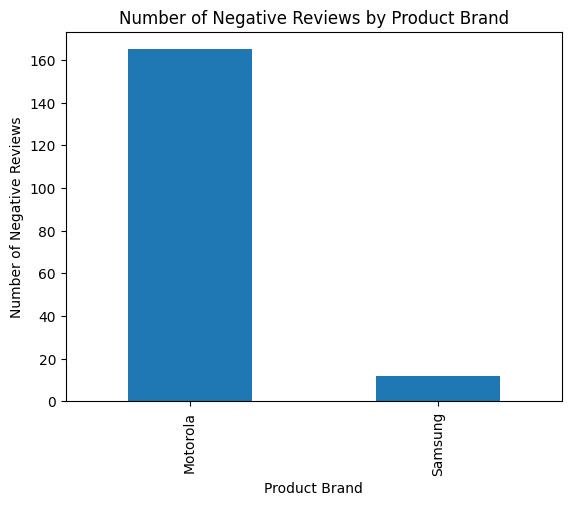

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the sentiment analysis results
results_df = pd.read_csv("/content/sentiment_analysis_results.csv")

# Count the number of negative reviews for each product brand
negative_reviews_count = results_df[results_df["label"] == "negative"].groupby("product_brand").size()

# Plot the number of negative reviews for each product brand
negative_reviews_count.plot(kind="bar")
plt.xlabel("Product Brand")
plt.ylabel("Number of Negative Reviews")
plt.title("Number of Negative Reviews by Product Brand")
plt.show()


### Negative Review on Camera

In [20]:
def main():
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'")
        return
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    # Load pre-trained model and tokenizer
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    # Get unique product brands
    unique_brands = data['product_brand'].unique()

    results = []
    for brand in unique_brands:
        brand_comments = data[data['product_brand'] == brand]['body']
        for comment in brand_comments:
            # Preprocess text (tokenize, convert to tensors)
            while True:
                encoded_input = tokenizer(comment, return_tensors='pt', truncation=True, max_length=512)
                try:
                    # Perform sentiment analysis
                    output = model(**encoded_input)
                    break
                except RuntimeError:  # retry with slightly shorter max_length
                    if encoded_input['input_ids'].shape[1] <= 1:
                        raise
                    encoded_input['input_ids'] = encoded_input['input_ids'][:, :-1]

            scores = output[0][0].detach().numpy()
            scores = softmax(scores)

            # Get sentiment label and score
            scores_dict = {
                'negative': scores[0],
                'neutral': scores[1],
                'positive': scores[2]
            }
            label = max(scores_dict, key=scores_dict.get)
            score = scores_dict[label]

            # Append results if the review is negative
            if label == 'negative':
                results.append({'product_brand': brand, 'comment': comment, 'label': label, 'score': score})

    # Create DataFrame of Negative Reviews
    negative_reviews_df = pd.DataFrame(results)

    # Filter for comments mentioning phone cameras
    camera_keywords = ['camera', 'photo', 'picture', 'image', 'lens', 'selfie']
    camera_reviews_df = negative_reviews_df[negative_reviews_df['comment'].str.contains('|'.join(camera_keywords), case=False)]

    # Summarize Sentiment by Brand for Camera-Related Negative Reviews
    sentiment_summary = camera_reviews_df.groupby('product_brand')['label'].value_counts().unstack(fill_value=0)

    # Calculate Proportions
    sentiment_summary_pct = sentiment_summary.div(sentiment_summary.sum(axis=1), axis=0) * 100

    print("\nSentiment Analysis Summary by Brand (Negative Reviews on Camera):")
    print(sentiment_summary)
    print("\nSentiment Proportions by Brand (Negative Reviews on Camera) (%):")
    print(sentiment_summary_pct.round(2))

    # Save the results
    camera_reviews_df.to_csv("camera_negative_reviews.csv", index=False)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Sentiment Analysis Summary by Brand (Negative Reviews on Camera):
label          negative
product_brand          
Motorola              7
Samsung               1

Sentiment Proportions by Brand (Negative Reviews on Camera) (%):
label          negative
product_brand          
Motorola          100.0
Samsung           100.0


Bar Chart for Camera

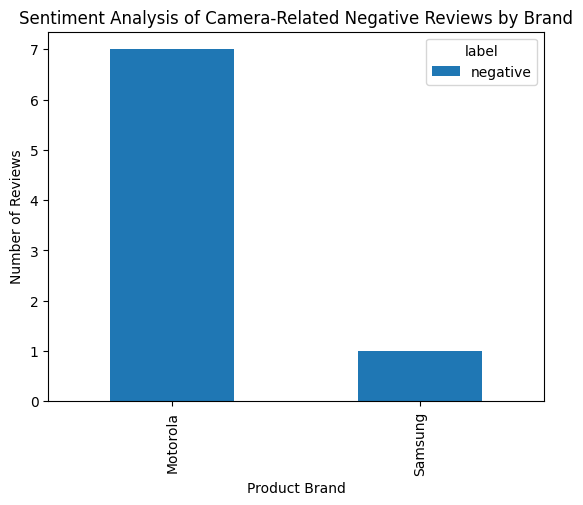

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('/content/camera_negative_reviews.csv')

# Group the data by product brand and sentiment label
grouped_data = df.groupby(['product_brand', 'label']).size().unstack()

# Create a bar plot
grouped_data.plot(kind='bar', stacked=True)
plt.title('Sentiment Analysis of Camera-Related Negative Reviews by Brand')
plt.xlabel('Product Brand')
plt.ylabel('Number of Reviews')
plt.show()


## Distilroberta

In [22]:
def main():
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'")
        return
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    # Load pre-trained model and tokenizer
    MODEL = f"mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    # Get unique product brands
    unique_brands = data['product_brand'].unique()

    results = []
    for brand in unique_brands:
        brand_comments = data[data['product_brand'] == brand]['body']
        for comment in brand_comments:
            # Preprocess text (tokenize, convert to tensors)
            while True:
                encoded_input = tokenizer(comment, return_tensors='pt', truncation=True, max_length=512)
                try:
                    # Perform sentiment analysis
                    output = model(**encoded_input)
                    break
                except RuntimeError:  # retry with slightly shorter max_length
                    if encoded_input['input_ids'].shape[1] <= 1:
                        raise
                    encoded_input['input_ids'] = encoded_input['input_ids'][:, :-1]

            scores = output[0][0].detach().numpy()
            scores = softmax(scores)

            # Get sentiment label and score
            scores_dict = {
                'negative': scores[0],
                'neutral': scores[1],
                'positive': scores[2]
            }
            label = max(scores_dict, key=scores_dict.get)
            score = scores_dict[label]

            # Append results if the review is negative
            if label == 'negative':
                results.append({'product_brand': brand, 'comment': comment, 'label': label, 'score': score})

    # Create DataFrame of Negative Reviews
    negative_reviews_df = pd.DataFrame(results)

    # Filter for comments mentioning phone cameras
    camera_keywords = ['camera', 'photo', 'picture', 'image', 'lens', 'selfie']
    camera_reviews_df = negative_reviews_df[negative_reviews_df['comment'].str.contains('|'.join(camera_keywords), case=False)]

    # Summarize Sentiment by Brand for Camera-Related Negative Reviews
    sentiment_summary = camera_reviews_df.groupby('product_brand')['label'].value_counts().unstack(fill_value=0)

    # Calculate Proportions
    sentiment_summary_pct = sentiment_summary.div(sentiment_summary.sum(axis=1), axis=0) * 100

    print("\nSentiment Analysis Summary by Brand (Negative Reviews on Camera):")
    print(sentiment_summary)
    print("\nSentiment Proportions by Brand (Negative Reviews on Camera) (%):")
    print(sentiment_summary_pct.round(2))

    # Save the results
    camera_reviews_df.to_csv("Distilrobert camera_negative_reviews.csv", index=False)

if __name__ == "__main__":
    main()


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]


Sentiment Analysis Summary by Brand (Negative Reviews on Camera):
label          negative
product_brand          
Motorola              2

Sentiment Proportions by Brand (Negative Reviews on Camera) (%):
label          negative
product_brand          
Motorola          100.0


# By Downloading Huggingface Model (For use in local Machine)

### Git installation and clone the model

In [23]:
!git lfs install

Git LFS initialized.


In [24]:
!git clone https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

Cloning into 'twitter-roberta-base-sentiment-latest'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 49 (delta 24), reused 49 (delta 24), pack-reused 0 (from 0)
Unpacking objects: 100% (49/49), 541.17 KiB | 3.71 MiB/s, done.
Filtering content: 100% (2/2), 953.57 MiB | 44.17 MiB/s, done.


In [25]:
!ls

 camera_negative_reviews.csv		     sample_data
 cleaned_dataset.csv			     sentiment_analysis_results.csv
'Distilrobert camera_negative_reviews.csv'   twitter-roberta-base-sentiment-latest
 Feedback_Analysis


### Install tree

In [26]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (60.1 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121918 files and directories currently instal

### Folder tree of downloaded model

In [27]:
!cd twitter-roberta-base-sentiment-latest && tree -L 2

.
├── config.json
├── merges.txt
├── pytorch_model.bin
├── README.md
├── special_tokens_map.json
├── tf_model.h5
└── vocab.json

0 directories, 7 files


### Sample code for testing

In [ ]:
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Path to the model and tokenizer files
model_dir = 'twitter-roberta-base-sentiment-latest'

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_dir)

# Load the model
model = TFRobertaForSequenceClassification.from_pretrained(model_dir, from_pt=True)

# Function to perform sentiment analysis
def predict_sentiment(texts):
    # Tokenize the input text
    inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True)

    # Get model predictions
    outputs = model(inputs)
    predictions = tf.nn.softmax(outputs.logits, axis=-1)

    # Get the predicted class
    predicted_classes = tf.argmax(predictions, axis=1)

    return predicted_classes

# Example usage
texts = [
    "I love this product!",
    "This is the worst thing I've ever bought."
]

predicted_classes = predict_sentiment(texts)

# Convert predicted classes to sentiment labels
labels = ['Negative', 'Neutral', 'Positive']  # Adjust based on the number of classes
predicted_labels = [labels[int(pred)] for pred in predicted_classes]

for text, label in zip(texts, predicted_labels):
    print(f"Text: {text} -> Sentiment: {label}")
